In [1]:
import glob
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr   
import itertools as it
import Colors
from neupy import algorithms

In [2]:
pwd

u'/Users/anna/Dropbox/gastruloids/data/mGstl-tomo/notebooks'

# read data

In [3]:
files = glob.glob('/Users/anna/Dropbox/gastruloids/data/mGstl-tomo/mG*5d/rawdata/mG*trim_star_spliced.coutt*')

In [4]:
dfs = [read_csv(f, sep = '\t', index_col=0).astype(int) for f in files]

# remove genes

In [5]:
def removeGenes(df):
    genes = ['ERCC','chrM', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('__')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]

In [6]:
fdfs = [removeGmGenes(removeGenes(df)) for df in dfs]

In [7]:
fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]

# normalization

In [8]:
nfdfs = [df.sum().mean()*df/df.sum() for df in fdfs]

# z-scores

In [9]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [10]:
znfdfs = [zscore(df) for df in nfdfs]
sznfdfs = [scalezscore(df) for df in znfdfs]

# coeficient of variation

In [11]:
def vargenes(df):
    df = df.loc[df.index[df.sum(axis=1)!=0]]
    cvdf = pd.DataFrame({'mu': df.mean(axis=1), 'var': df.var(axis=1)})
    cvdf['cv'] = np.sqrt(cvdf['var'])/cvdf['mu']
    cvdf['r'] = np.log10(cvdf['mu'])
    cvdf['s'] = np.log10(cvdf['cv'])
    a = -0.5; b = 0 # straight line for poisson cv
    cvdf['xmin'] = (a*cvdf['s']-a*b-cvdf['r'])/(a**2-1)
    cvdf['ymin'] = a*cvdf['xmin'] + b
    cvdf['dist'] = np.sqrt((cvdf['r']-cvdf['xmin'])**2+(cvdf['s']-cvdf['ymin'])**2)
    cvdf = cvdf.sort_values(by='dist', ascending = False)
    return cvdf

In [12]:
cvnfdfs = [vargenes(df) for df in nfdfs]

In [13]:
def getOverlappingGenes(dfs, N):
    cvdfs = [vargenes(df) for df in dfs]
    vdfs = [dfs[i].loc[cvdfs[i].sort_values(by='dist', ascending=False).index[:N]] for i in range(len(dfs))]
    allGenes = [g for vdf in vdfs for g in vdf.index ]
    cnt = Counter(allGenes)
    overlapping = [g for g in cnt if cnt[g] == len(dfs)]
    return pd.Series(overlapping)

In [14]:
og_nfdfs = []
N = 1000
while len(og_nfdfs) < 1000:
    og_nfdfs = getOverlappingGenes(nfdfs, N)
    N += 50
print N

5000


In [15]:
og_nfdfs = getOverlappingGenes(nfdfs, 5271)
len(og_nfdfs)

1086

# hierarchical clustering on variable genes

In [16]:
def hierarchicalClustering(df):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=100, no_plot = True)
    plt.show()
    return Z, dg

In [17]:
def mergedfs(dfs):
    mdf = dfs[0]
    for df in dfs[1:]:
        mdf = mdf.merge(df, how = 'inner', left_index = True, right_index = True)
        mdf = mdf.fillna(0)
    return mdf

In [18]:
mznfdfs = mergedfs(znfdfs)
msznfdfs = mergedfs(sznfdfs)

In [19]:
Z, dg = hierarchicalClustering(mznfdfs.loc[og_nfdfs])

In [20]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2',
          'Mesp2','Ripply2','Dppa5a','Gata6','Meox1','Tbx6','T']

In [21]:
for g in g_annotate:
    print g, [idx for idx in mznfdfs.index if '_' + g + '__' in idx]

annotate = []
for g in g_annotate:
    gs = [idx for idx in msznfdfs.index if '_' + g + '__' in idx]
    if len(gs) == 1:
        annotate.append(gs[0])

Cdx2 ['ENSMUSG00000029646_Cdx2__5']
Rspo3 ['ENSMUSG00000019880_Rspo3__10']
Sox1 ['ENSMUSG00000096014_Sox1__8']
Sox2 ['ENSMUSG00000074637_Sox2__3']
Wnt3a ['ENSMUSG00000009900_Wnt3a__11']
Fgf8 ['ENSMUSG00000025219_Fgf8__19']
Uncx ['ENSMUSG00000029546_Uncx__5']
Aldh1a2 ['ENSMUSG00000013584_Aldh1a2__9']
Mesp2 ['ENSMUSG00000030543_Mesp2__7']
Ripply2 ['ENSMUSG00000047897_Ripply2__9']
Dppa5a ['ENSMUSG00000060461_Dppa5a__9']
Gata6 ['ENSMUSG00000005836_Gata6__18']
Meox1 ['ENSMUSG00000001493_Meox1__11']
Tbx6 ['ENSMUSG00000030699_Tbx6__7']
T ['ENSMUSG00000062327_T__17']


In [22]:
def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

/Users/anna/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


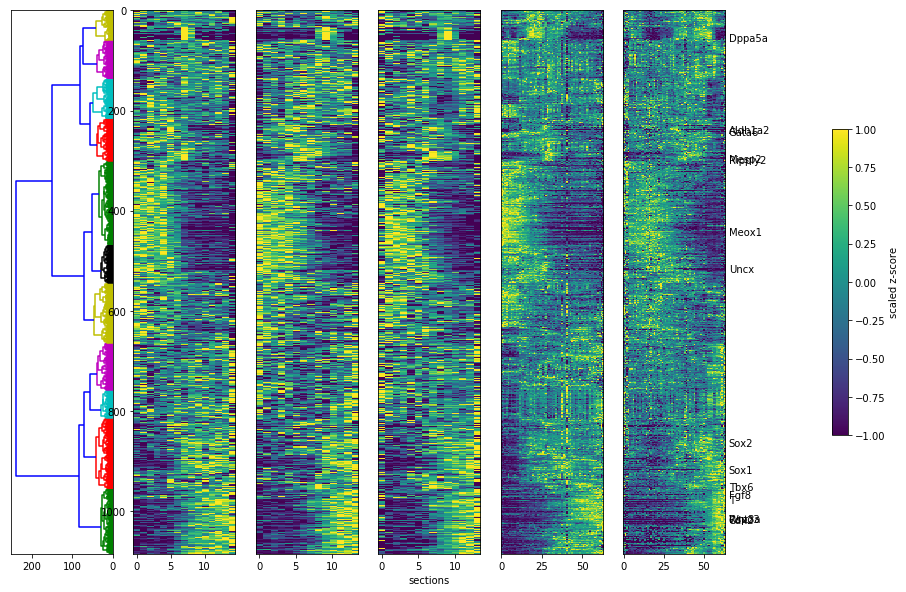

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(171)
dgc = dendrogram(Z, no_labels=True, color_threshold=50, orientation='left')

for i in range(len(nfdfs)):
    plt.subplot(1,7,i+2)
    plt.imshow(msznfdfs.loc[og_nfdfs[dg['leaves']][::-1], nfdfs[i].columns], aspect = 'auto')
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(nfdfs)-1:
        plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
        plt.yticks(range(len(og_nfdfs)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in og_nfdfs[dg['leaves']][::-1]])

plt.subplot(177, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(og_nfdfs))+'variablegenes_blueyellow_tree.pdf', bbox_inches = 'tight')

plt.show()

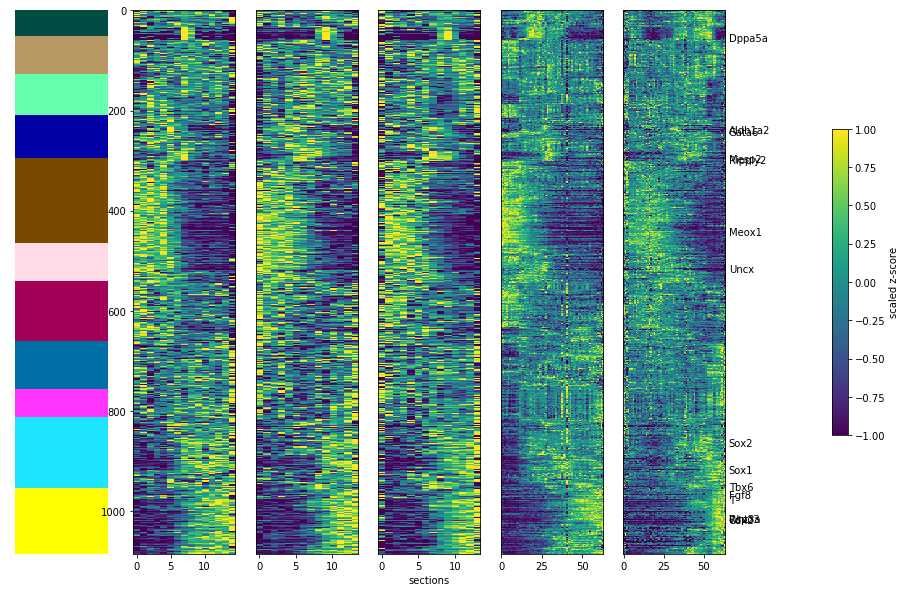

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(171, frameon = False)
dgc = dendrogram(Z, no_labels=True, color_threshold=50, orientation='left', no_plot=True)
geneClusters = getClusterByColor(dgc, og_nfdfs)
geneClustersdf = pd.Series({g: i for i in geneClusters.keys() for g in geneClusters[i]})
geneClustersdf = geneClustersdf.sort_values()
y0 = 0
for i in set(geneClustersdf):
    y = 1.0*(geneClustersdf[geneClustersdf == i].shape[0]+1)/(geneClustersdf.shape[0]+1)
    plt.bar([4], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y        
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)

for i, df in enumerate(sznfdfs):
    plt.subplot(1,7,i+2)
    plt.imshow(df.loc[og_nfdfs[dg['leaves']][::-1]], aspect = 'auto')
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(sznfdfs)-1:
        plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
        plt.yticks(range(len(og_nfdfs)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in og_nfdfs[dg['leaves']][::-1]])

plt.subplot(177, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(og_nfdfs))+'variablegenes_blueyellow.pdf', bbox_inches = 'tight')

plt.show()

In [25]:
#geneClustersdf.to_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(og_nfdfs))+'variablegenes_clusters.txt', sep = '\t')

In [26]:
set(geneClustersdf)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

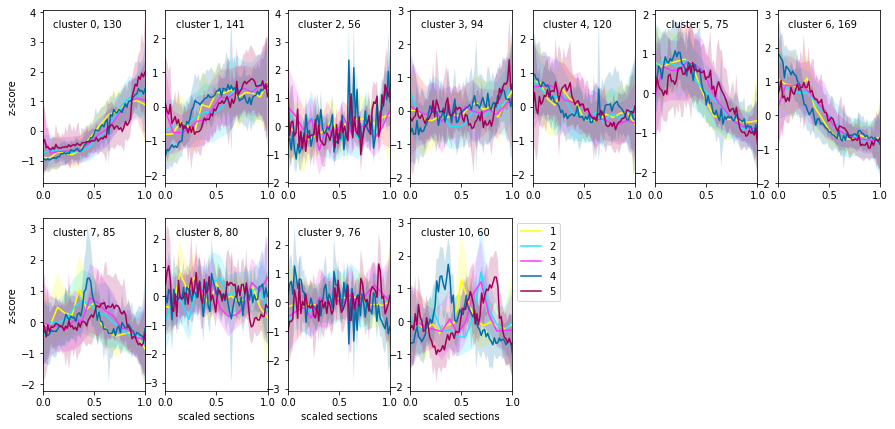

In [27]:
fig = plt.figure(figsize=(15,7))

for cl in geneClusters.keys():
    ax = fig.add_subplot(2,7,cl+1)
    genes = geneClustersdf[geneClustersdf==cl].index
    for i, df in enumerate(znfdfs):
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
    ax.text(0.1,.9, 'cluster ' + str(cl) +', ' +str(len(genes)), horizontalalignment='left', transform=ax.transAxes)
    if cl == 0 or cl == 7:
        plt.ylabel('z-score')
    if cl >= 7:
        plt.xlabel('scaled sections')
    plt.xlim(0,1)
plt.legend([1,2,3,4,5], loc = 2, bbox_to_anchor = (1,1))
#plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(og_nfdfs))+'variablegenes_clusters.pdf', bbox_inches = 'tight')
plt.show()

# Gene correlation analysis

In [28]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [29]:
cdf = {i: {j: 0 for j in range(len(znfdfs))} for i in range(len(znfdfs))}
for i1, i2 in it.combinations(range(len(znfdfs)),2):
    print i1, i2
    cdf[i1][i2] = geneCorrelation(znfdfs[i1], znfdfs[i2])
    cdf[i2][i1] = geneCorrelation(znfdfs[i2], znfdfs[i1])

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


/Users/anna/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


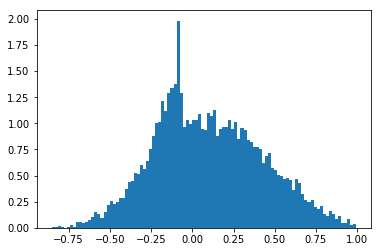

In [30]:
plt.hist(cdf[0][1], bins = 100, normed=True)
plt.show()

# Simulations to know what is significant

In [31]:
def simulationCorrelations(n1, n2, N = 1000, th = 0.01):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    hist = np.histogram(ps, bins = 100, normed=True)
    hdf = pd.DataFrame({'prob': hist[0], 'corr': [hist[1][i:i+2].mean() for i in range(len(hist[0]))]})
    dx = hdf.loc[1,'corr']-hdf.loc[0,'corr']
    hdf['cum'] = hdf['prob'].cumsum()*dx
    canti = hdf.loc[hdf[hdf['cum']<=th].index[-1], 'corr']
    ccorr = hdf.loc[hdf[hdf['cum']>=1-th].index[0], 'corr']
    return ps, canti, ccorr

In [32]:
# particular case gastruloid 1 versus gastruloid 2
ps01, canti01, ccorr01 = simulationCorrelations(len(znfdfs[0].columns), len(znfdfs[1].columns), N = 1000, th = 0.01)
ps05, canti05, ccorr05 = simulationCorrelations(len(znfdfs[0].columns), len(znfdfs[1].columns), N = 1000, th = 0.05)

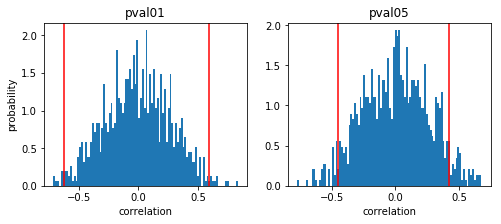

In [33]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(ps01, bins = 100, normed=True)
plt.axvline(canti01, c= 'r')
plt.axvline(ccorr01, c= 'r')
plt.title('pval01')
plt.xlabel('correlation')
plt.ylabel('probability')

plt.subplot(122)
plt.hist(ps05, bins = 100, normed=True)
plt.axvline(canti05, c= 'r')
plt.axvline(ccorr05, c= 'r')
plt.title('pval05')
plt.xlabel('correlation')
plt.show()

# Select genes per gastruloid pairs

In [34]:
corrGenesdf01 = {i: {j: [] for j in range(len(znfdfs))} for i in range(len(znfdfs))}
corrGenesdf05 = {i: {j: [] for j in range(len(znfdfs))} for i in range(len(znfdfs))}
np.random.seed(12345)
for i1, i2 in it.combinations(range(len(znfdfs)),2):
    print i1, i2
    ps, ca, cc = simulationCorrelations(len(znfdfs[i1].columns), len(znfdfs[i2].columns), N = 10000, th = 0.05)
    corrGenesdf05[i1][i2] = list(cdf[i1][i2][cdf[i1][i2]>cc].index)
    ps, ca, cc = simulationCorrelations(len(znfdfs[i2].columns), len(znfdfs[i1].columns), N = 10000, th = 0.05)
    corrGenesdf05[i2][i1] = list(cdf[i2][i1][cdf[i2][i1]>cc].index)
    ps, ca, cc = simulationCorrelations(len(znfdfs[i1].columns), len(znfdfs[i2].columns), N = 10000, th = 0.01)
    corrGenesdf01[i1][i2] = list(cdf[i1][i2][cdf[i1][i2]>cc].index)
    ps, ca, cc = simulationCorrelations(len(znfdfs[i2].columns), len(znfdfs[i1].columns), N = 10000, th = 0.01)
    corrGenesdf01[i2][i1] = list(cdf[i2][i1][cdf[i2][i1]>cc].index)
    

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


In [35]:
cnt01 = Counter()
cnt05 = Counter()
for i1, i2 in it.combinations(range(len(znfdfs)),2):
    cnt01.update(list(set(corrGenesdf01[i1][i2] + corrGenesdf01[i2][i1])))
    cnt05.update(list(set(corrGenesdf05[i1][i2] + corrGenesdf05[i2][i1])))

In [36]:
corrgenes01 = pd.Series([g for g in cnt01 if cnt01[g]>=5 and g in msznfdfs.index])
corrgenes05 = pd.Series([g for g in cnt05 if cnt05[g]>=5 and g in msznfdfs.index])

In [37]:
[len(df.index) for df in znfdfs]

[15988, 16669, 16391, 21136, 20557]

In [38]:
len(corrgenes01), len(corrgenes05)

(671, 1377)

In [39]:
corrgenes = corrgenes05

In [40]:
[100*1197./len(df.index) for df in znfdfs]

[7.4868651488616464,
 7.180994660747495,
 7.302788115429199,
 5.66332323996972,
 5.822834071119327]

In [41]:
Z, dg = hierarchicalClustering(mznfdfs.loc[corrgenes])

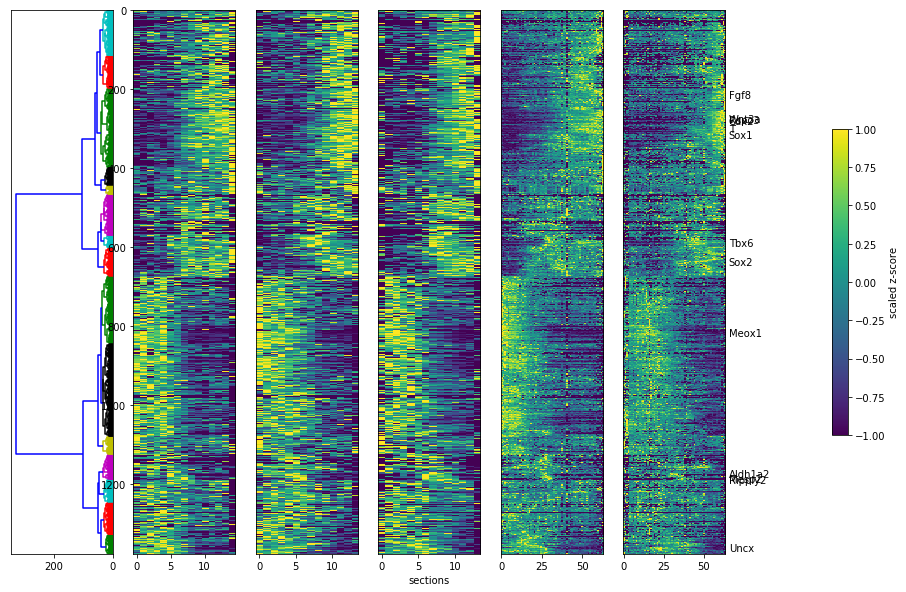

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(171)
dgc = dendrogram(Z, no_labels=True, color_threshold=40, orientation='left')
for i in range(len(nfdfs)):
    plt.subplot(1,7,i+2)
    plt.imshow(msznfdfs.loc[corrgenes[dg['leaves']][::-1], nfdfs[i].columns], aspect = 'auto')
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(nfdfs)-1:
        plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
        plt.yticks(range(len(corrgenes)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in corrgenes[dg['leaves']][::-1]])

plt.subplot(177, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(corrgenes05))+'corrgenes05_hclust_tree_blueyellow.pdf', bbox_inches = 'tight')
plt.show()

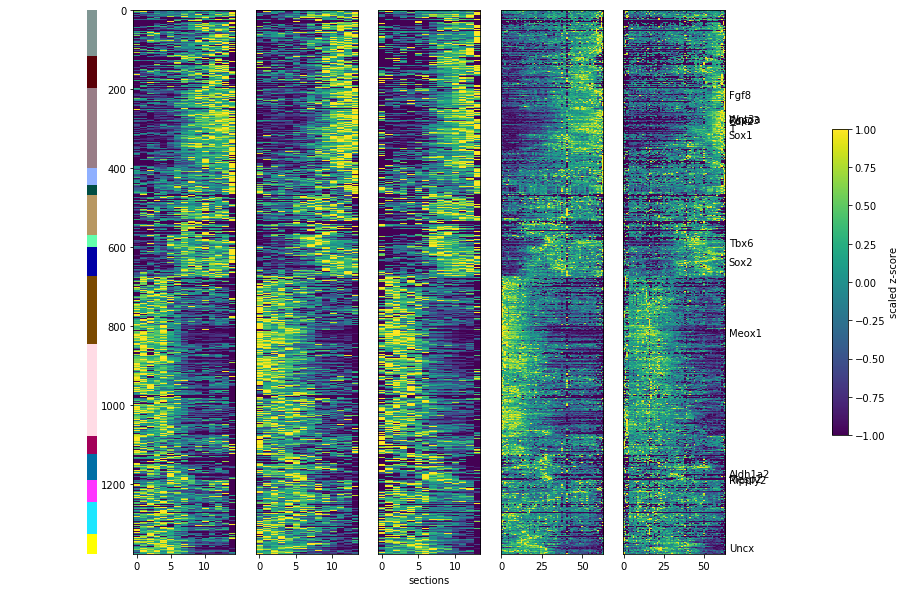

In [43]:
plt.figure(figsize=(15,10))

plt.subplot(171, frameon = False)
dgc = dendrogram(Z, no_labels=True, color_threshold=40, orientation='left', no_plot=True)
geneClusters2 = getClusterByColor(dgc, corrgenes)
geneClusters2df = pd.Series({g: i for i in geneClusters2.keys() for g in geneClusters2[i]})
geneClusters2df = geneClusters2df.sort_values()
y0 = 0
for i in sorted(set(geneClusters2df)):
    y = 1.0*len(geneClusters2df[geneClusters2df == i])/len(geneClusters2df)
    plt.bar([4], [y], bottom = y0, width = .5, color = Colors.colors[i])
    y0 += y        
plt.yticks([]); plt.xticks([])
plt.ylim(0,1); plt.xlim(0,5)

for i, df in enumerate(sznfdfs):
    plt.subplot(1,7,i+2)
    plt.imshow(df.loc[corrgenes[dg['leaves']][::-1]], aspect = 'auto')
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(sznfdfs)-1:
        plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
        plt.yticks(range(len(corrgenes)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in corrgenes[dg['leaves']][::-1]])

plt.subplot(177, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
#plt.savefig(path + 'fig1d_heatmap_'+str(len(corrgenes05))+'corrgenes_hclust_blueyellow.pdf', bbox_inches = 'tight')
plt.show()

In [44]:
# geneClusters2df.to_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(corrgenes05))+'corrgenes_hclust.txt', sep = '\t')

In [45]:
geneClusters2.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

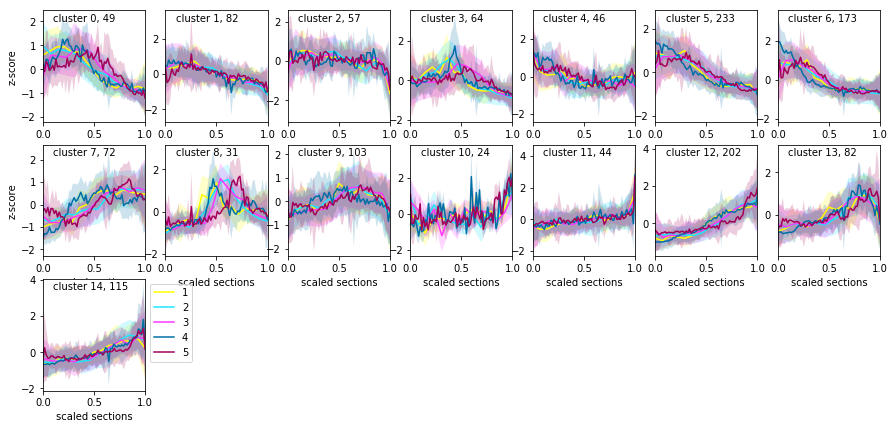

In [46]:
fig = plt.figure(figsize=(15,7))

for i in geneClusters2.keys():
    ax = fig.add_subplot(3,7,i+1)
    for j, df in enumerate(znfdfs):
        genes = geneClusters2df[geneClusters2df==i].index
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()

        ax.plot(xra, mu, c = Colors.colors[j])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[j], interpolate=True, alpha = 0.2)
    ax.text(0.1,.9, 'cluster ' + str(i) +', ' +str(len(genes)), horizontalalignment='left', transform=ax.transAxes)
    plt.xlim(0,1)
    if i == 0 or i == 7:
        plt.ylabel('z-score')
    if i >= 7:
        plt.xlabel('scaled sections')
        
#plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_'+str(len(corrgenes05))+'corrgenes_hclusters.pdf', bbox_inches = 'tight')
plt.legend([1,2,3,4,5], loc = 2, bbox_to_anchor = (1,1))
plt.show()

# self organizing maps with correlated genes

In [47]:
GRID_HEIGHT = 10
GRID_WIDTH = 10

somfunc = algorithms.SOFM(
            n_inputs=len(mznfdfs.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)

In [48]:
somfunc.train(np.array(mznfdfs.loc[corrgenes]), epochs = 300)

In [49]:
clustersr = somfunc.predict(np.array(mznfdfs.loc[corrgenes])).argmax(axis=1)
cl_corrGenes_df = pd.Series(clustersr, index = corrgenes)

In [50]:
cnt = Counter(clustersr).most_common()
print cnt[0], cnt[-1]

(80, 57) (89, 4)


In [51]:
mudf = pd.DataFrame({i: mznfdfs.loc[cl_corrGenes_df[cl_corrGenes_df==i].index].mean() for i in set(clustersr) })

In [52]:
hclsom = linkage(mudf.T, method='ward', metric='euclidean')

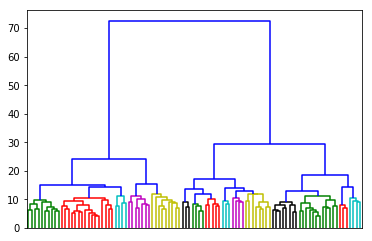

In [53]:
dg = dendrogram(hclsom, no_labels=True, color_threshold = 12)
plt.show()

In [54]:
hcldic = getClusterByColor(dg, mudf.columns)

In [55]:
geneclsomdf = pd.DataFrame(cl_corrGenes_df, columns = ['som'])
geneclsomdf['hcl'] = [k for s in geneclsomdf['som'] for k in hcldic.keys() if s in hcldic[k]]

In [56]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
geneclsomdf.to_csv(path + 'fig1d_heatmap_'+str(len(geneclsomdf))+'corrgenes_SOMclusters.txt', sep = '\t')

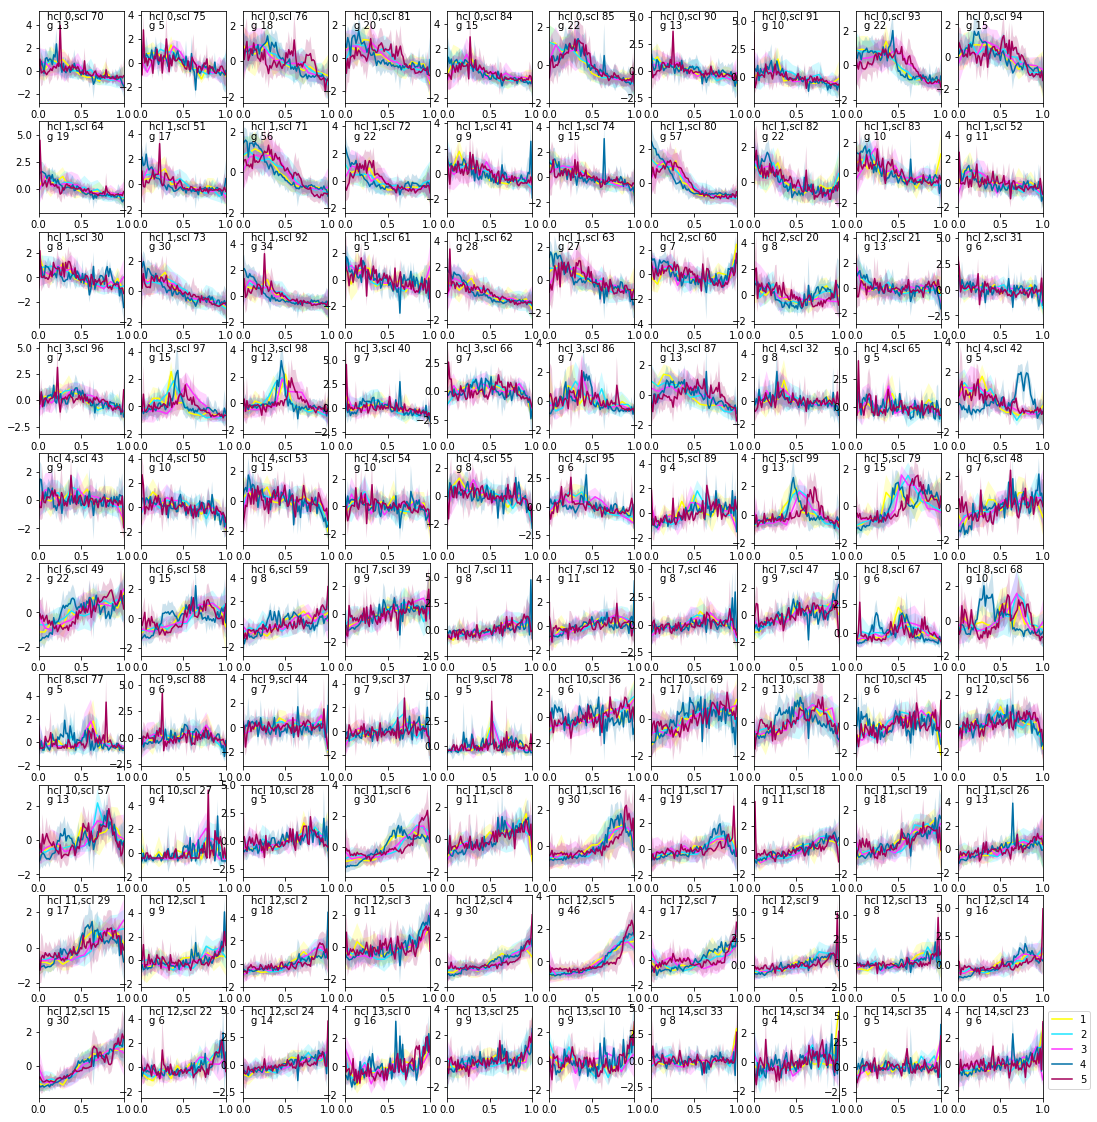

In [57]:
fig = plt.figure(figsize=(18,20))
k = 0
for hcl in set(geneclsomdf['hcl']):
    for cl in set(geneclsomdf[geneclsomdf['hcl']==hcl]['som']):
        k += 1
        ax = fig.add_subplot(10,10,k)
        genes = geneclsomdf[geneclsomdf['som']==cl].index
        for i, df in enumerate(znfdfs):
            xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
            mu = df.loc[genes].mean()
            mup = mu + df.loc[genes].std()
            mum = mu - df.loc[genes].std()#

            ax.plot(xra, mu, c = Colors.colors[i])
            ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
        title1 = 'hcl ' + str(hcl) +',scl '+str(cl)
        title2 = 'g '+str(len(genes))
        ax.text(0.1,.9,title1, horizontalalignment='left', transform=ax.transAxes)
        ax.text(0.1,.8,title2, horizontalalignment='left', transform=ax.transAxes)
        plt.xlim(0,1)
plt.legend(np.arange(len(znfdfs))+1, loc = 2, bbox_to_anchor = (1,1))

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
plt.savefig(path + 'fig1d_heatmap_'+str(len(geneclsomdf))+'corrgenes_allSOMclusters.pdf', bbox_inches = 'tight')
plt.show()

In [58]:
set(geneclsomdf['hcl'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

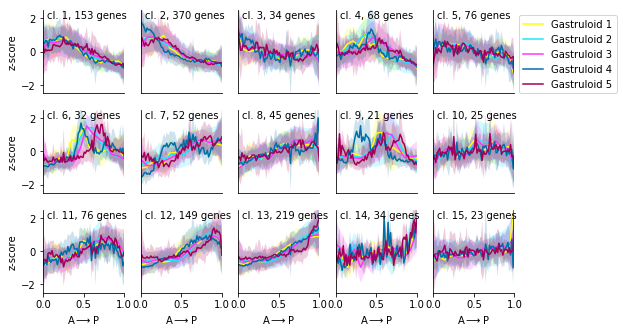

In [64]:
fig = plt.figure(figsize=(13*0.65,8*0.65))

for cl in set(geneclsomdf['hcl']):
    ax = fig.add_subplot(3,5,cl+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    genes = geneclsomdf[geneclsomdf['hcl']==cl].index
    for i, df in enumerate(znfdfs):
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
        plt.ylim(-2.5,2.5)
    ax.text(0.05,.9,'cl. ' + str(cl+1)+', '+ str(len(genes)) + ' genes ', horizontalalignment='left', transform=ax.transAxes)
    if cl in [0,5,10]:
        plt.ylabel('z-score')
    if cl in [0,5,10]:
        plt.yticks([-2,0,2])
    else:
        plt.yticks([])
    if cl >= 10:
        plt.xticks([0,0.5,1])
    else:
        plt.xticks([])
    if cl >= 10:
        plt.xlabel(r'$\rm{A} \longrightarrow \rm{P}$')
    plt.xlim(0,1)
    if cl == 4:
        plt.legend(['Gastruloid ' + str(i) for i in np.arange(1,len(znfdfs)+1)], loc = 2, bbox_to_anchor = (1,1))

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
plt.savefig(path + 'fig1d_heatmap_'+str(len(geneclsomdf))+'corrgenes_hclSOMclusters.pdf', bbox_inches = 'tight')

plt.show()

In [60]:
pd.Series(geneclsomdf['hcl']+1).to_csv(path + 'Extended-Dataset_1.tsv', sep = '\t')

In [61]:
path

'/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'

In [62]:
! open /Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/Extended-Dataset_1.tsv

In [63]:
geneclsomdf = geneclsomdf.sort_values(by=['hcl','som'])
gene_order = geneclsomdf.index

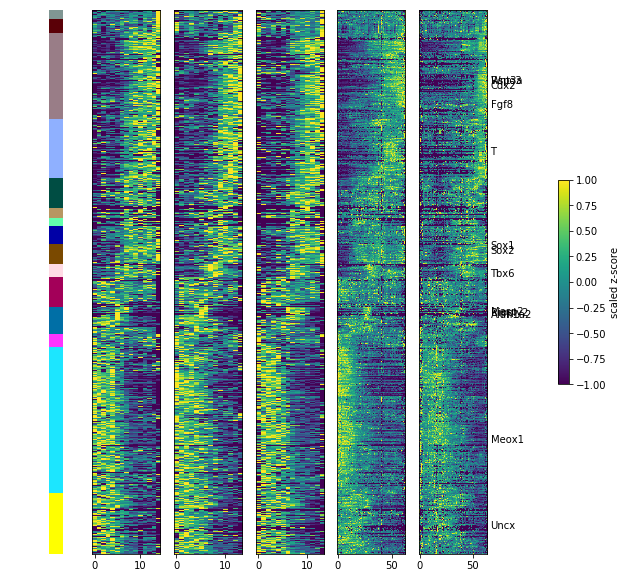

In [64]:
plt.figure(figsize=(10,10))

plt.subplot(1,len(sznfdfs)+2,1, frameon = False)
y0 = 0; z0 = 0
for i in set(geneclsomdf['hcl']):
    y = 1.0*geneclsomdf[geneclsomdf['hcl'] == i].shape[0]/geneclsomdf.shape[0]
    plt.bar([3.5], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y        

plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4)

for i, df in enumerate(sznfdfs):
    plt.subplot(1,len(sznfdfs)+2,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
    if i == len(sznfdfs)-1:
        plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
        plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in gene_order[::-1]])
   
plt.subplot(1,len(sznfdfs)+2, len(sznfdfs)+2, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
plt.savefig(path + 'fig1d_heatmap_'+str(len(geneclsomdf))+'corrgenes_SOMclusters.pdf', bbox_inches = 'tight')

plt.show()

##### 

In [65]:
len(nfdfs)

5

In [66]:
files[0].replace('rawdata','normdata').replace('coutt','ncoutt')

'/Users/anna/Dropbox/gastruloids/data/mGstl-tomo/mG01-20umAP-5d/normdata/mG01_trim_star_spliced.ncoutt.tsv'

In [67]:
! ls /Users/anna/Dropbox/gastruloids/data/mGstl-tomo/mG01-20umAP-5d/

downdata                            meanOversequencing-mG01mG02mG03.pdf
fig1_data_plots                     normdata
figsQC                              rawdata


In [68]:
for i, df in enumerate(nfdfs):
    outfile = files[i].replace('rawdata','normdata').replace('coutt','ncoutt')
    df.to_csv(outfile, sep = '\t')

# PCA

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(n_components=5).fit(mznfdfs.T)
pca_xy = pca.transform(mznfdfs.T)

In [71]:
mznfdfs.shape

(13991, 170)

In [72]:
pcacompdf = pd.DataFrame(pca.components_, columns = mznfdfs.index, index = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5']).T

In [73]:
pcadf = pd.DataFrame(pca_xy, index = mznfdfs.columns, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5'])

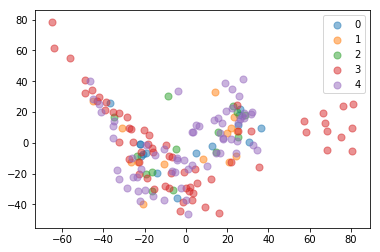

In [74]:
for df in znfdfs:
    plt.scatter(pcadf.loc[df.columns,'pca1'], pcadf.loc[df.columns,'pca2'], alpha = 0.5, s = 50)
plt.legend(range(len(znfdfs)))
plt.show()

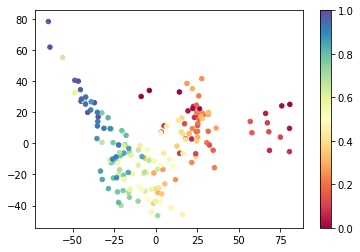

In [75]:
for df in znfdfs:
    xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
    plt.scatter(pcadf.loc[df.columns,'pca1'], pcadf.loc[df.columns,'pca2'], s = 20, c = xra, cmap = 'Spectral')
plt.colorbar()
plt.show()

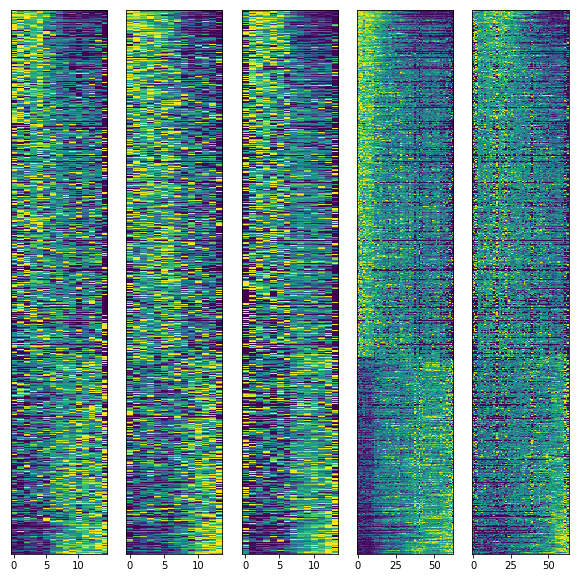

In [76]:
plt.figure(figsize=(10,10))
for i, df in enumerate(sznfdfs):
    plt.subplot(1,len(sznfdfs),i+1)
    genes = pcacompdf[abs(pcacompdf['pca1'])>0.01]['pca1'].sort_values(ascending=False).index
    plt.imshow(df.loc[genes], aspect = 'auto')
    plt.yticks([])
plt.show()

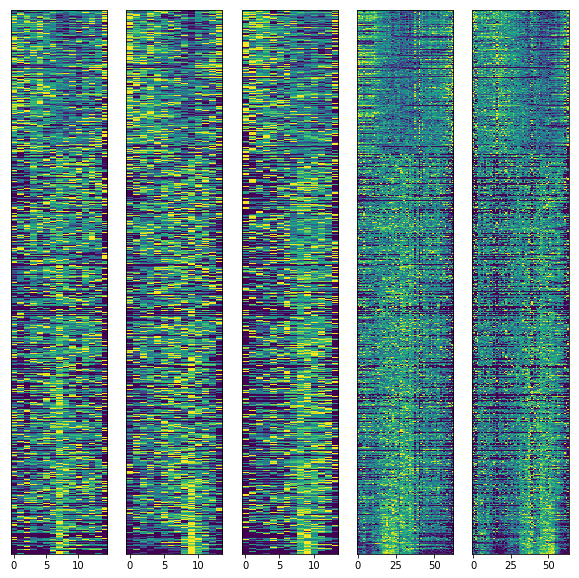

In [77]:
plt.figure(figsize=(10,10))
for i, df in enumerate(sznfdfs):
    plt.subplot(1,len(sznfdfs),i+1)
    genes = pcacompdf[abs(pcacompdf['pca2'])>0.01]['pca2'].sort_values(ascending=False).index
    plt.imshow(df.loc[genes], aspect = 'auto')
    plt.yticks([])
plt.show()

# Average gastruloid

In [97]:
g = 'ENSMUSG00000062327_T__17'
g = 'ENSMUSG00000009900_Wnt3a__11'

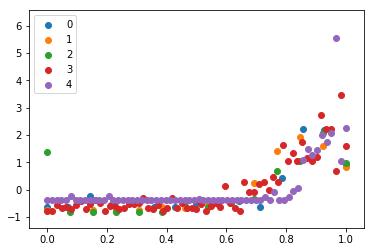

In [98]:
for df in znfdfs:
    xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
    plt.scatter(xra, df.loc[g])
    plt.ylim(df.loc[g].min()-1,df.loc[g].max()+1)
plt.legend(range(len(znfdfs)))
plt.show()

In [99]:
mdf = mznfdfs.T

In [100]:
d = {}
for df in znfdfs:
    xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
    for i, c in enumerate(df.columns):
        d[c] = xra[i]

In [101]:
mdf['x'] = [d[idx] for idx in mdf.index]

In [102]:
mdf = mdf.sort_values(by = 'x', ascending=True)

In [103]:
def weightedAverage(df):
    cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in df.index)})
    m = [0 for c in df.columns]
    for g in cnt.keys():
        g_idxs = [idx for idx in df.index if g in idx]
        m += df.loc[g_idxs].mean()*len(g_idxs)
    m = m/len(df)
    return m

def runningWeightedAverage(mdf):
    i0 = 0
    i = 0
    j = 0
    cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in mdf.index)})
    xdf = pd.DataFrame(columns = mdf.columns)
    while i < len(mdf.index):
        g = mdf.index[i].rsplit('-')[-1]
        cnt.update([g])
        if all([cnt[g]>0 for g in cnt]):
#            xdf.loc[j] = mdf.iloc[i0:i].mean()
            xdf.loc[j] = weightedAverage(mdf.iloc[i0:i])
            cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in mdf.index)})
            j += 1
            i0 = i
        i += 1
    xdf.loc[j] = mdf.iloc[i0:i].mean()
    return xdf

In [104]:
xdf = runningWeightedAverage(mdf)

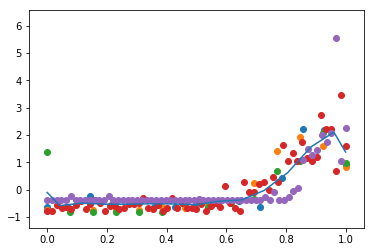

In [105]:
for df in znfdfs:
    xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
    plt.scatter(xra, df.loc[g])
    plt.ylim(df.loc[g].min()-1,df.loc[g].max()+1)

plt.plot(xdf['x'], xdf[g])
#plt.legend(range(len(znfdfs)))
plt.show()

In [106]:
xdf = xdf.T

In [107]:
xdf.to_csv('../average_zscore_mG01mG02mG03mG04mG05.tsv', sep = '\t')

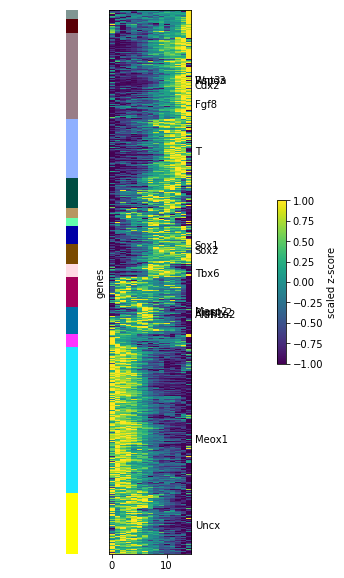

In [108]:
plt.figure(figsize=(5,10))

plt.subplot(1,3,1, frameon = False)
y0 = 0; z0 = 0
for i in set(geneclsomdf['hcl']):
    y = 1.0*geneclsomdf[geneclsomdf['hcl'] == i].shape[0]/geneclsomdf.shape[0]
    plt.bar([3.5], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  

plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)

plt.subplot(1,3,2)
plt.imshow(scalezscore(xdf.loc[gene_order[::-1]]), aspect='auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g in annotate else '' for g in gene_order[::-1]])
plt.ylabel('genes')

plt.subplot(1,3,3, frameon = False)
plt.colorbar(label = 'scaled z-score', shrink = 0.3)
plt.xticks([])
plt.yticks([])

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/'
plt.savefig(path + 'fig1d_heatmap_averageGst.pdf', bbox_inches ='tight')

plt.show()

In [109]:
pd.Series(gene_order).to_csv('../genelist_zscore_mG01mG02mG03mG04mG05.tsv', sep = '\t')

Fgf8, Wnt3a, Brachyury
Tbx6,
Lfng, (you could add Notch1 here as Lfng is a target of Notch, and Notch is highly expressed and clear in our data) Mesp2, Ripply2, Dll1,
Hes1, Hes5, Hey1, Hey2, Ctnnb1, Dusp4, Dusp6 (Maybe Anna could try to make a plot without and with the genes in this line, then we can decide after that which one to use)
Aldha1a2, Uncx, Tcf15
Hes1, Hes5, Hey1, Hey2, Ctnnb1, Dusp4, Dusp6

In [110]:
# somitogenesis = ['Fgf8', 'Wnt3a', 'T', 'Tbx6', 'Lfng', 'Notch1', 'Mesp2', 'Ripply2', 'Dll1', 'Hes1', 'Hes5', 'Hey1', 
#                 'Hey2', 'Ctnnb1', 'Dusp4', 'Dusp6', 'Aldh1a2', 'Uncx', 'Tcf15']
# somitogenesis = ['Fgf8', 'Wnt3a', 'T', 'Tbx6', 'Lfng', 'Notch1', 'Mesp2', 'Ripply2', 'Dll1', 'Aldh1a2', 'Uncx', 'Tcf15']
somitogenesis = ['Fgf8', 'Wnt3a', 'T', 'Tbx6', 'Dll1', 'Lfng', 'Mesp2', 
                 'Ripply2', 'Notch1', 'Aldh1a2', 'Uncx', 'Meox1', 'Tcf15']
somitogenes = []
for g in somitogenesis:
    print g, [idx for idx in xdf.index if '_' + g + '__' in idx]
    x = [idx for idx in xdf.index if '_' + g + '__' in idx][0]
    somitogenes.append(x)

Fgf8 ['ENSMUSG00000025219_Fgf8__19']
Wnt3a ['ENSMUSG00000009900_Wnt3a__11']
T ['ENSMUSG00000062327_T__17']
Tbx6 ['ENSMUSG00000030699_Tbx6__7']
Dll1 ['ENSMUSG00000014773_Dll1__17']
Lfng ['ENSMUSG00000029570_Lfng__5']
Mesp2 ['ENSMUSG00000030543_Mesp2__7']
Ripply2 ['ENSMUSG00000047897_Ripply2__9']
Notch1 ['ENSMUSG00000026923_Notch1__2']
Aldh1a2 ['ENSMUSG00000013584_Aldh1a2__9']
Uncx ['ENSMUSG00000029546_Uncx__5']
Meox1 ['ENSMUSG00000001493_Meox1__11']
Tcf15 ['ENSMUSG00000068079_Tcf15__2']


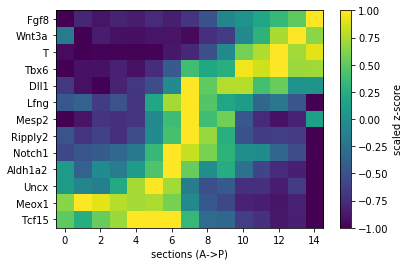

In [92]:
plt.imshow(scalezscore(xdf.loc[somitogenes]), aspect = 'auto')
plt.yticks(range(len(somitogenes)), somitogenesis)
plt.colorbar(label = 'scaled z-score')
plt.xlabel('sections (A->P)')
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSomitogenesis/'
plt.savefig(path + 'heatmap_avGst_somitoGenes.pdf')
plt.show()

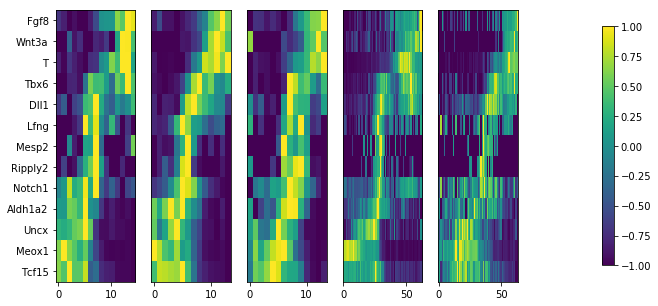

In [111]:
plt.figure(figsize=(10,5))
for i, df in enumerate(znfdfs):
    plt.subplot(1, len(znfdfs)+1, i+1)
    plt.imshow(scalezscore(df.loc[somitogenes]), aspect = 'auto')
    if i == 0:
        plt.yticks(range(len(somitogenes)), somitogenesis)
    else:
        plt.yticks([])
plt.subplot(1, len(znfdfs)+1, i+2, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar()

plt.savefig(path + 'heatmap_5Gst_somitoGenes.pdf')
plt.show()
    

In [112]:
scgenes = ['T','Ripply2','Aldh1a2','Mest','Dppa5a','Esrrb','Utf1','Klf2','Zfp42','Kdr',
           'Tie1','Sox7','Ctla2a','Cldn5','Mmrn2','Gng11','Cdh5','Sox18','Hoxa11','Tbx4',
           'Krt8','Krt18','Perp','Btbd17','Crabp1','Elavl3','Elavl4','Miat','Rhbdl3','Srrm4',
           'Tubb3']

SCgenes = []
for g in scgenes:
    xs = [x for x in znfdfs[0].index if '_' + g + '__' in x]
    print g, xs
    if len(xs)==1:
        SCgenes.append(xs[0])
    

T ['ENSMUSG00000062327_T__17']
Ripply2 ['ENSMUSG00000047897_Ripply2__9']
Aldh1a2 ['ENSMUSG00000013584_Aldh1a2__9']
Mest ['ENSMUSG00000051855_Mest__6']
Dppa5a ['ENSMUSG00000060461_Dppa5a__9']
Esrrb ['ENSMUSG00000021255_Esrrb__12']
Utf1 ['ENSMUSG00000047751_Utf1__7']
Klf2 ['ENSMUSG00000055148_Klf2__8']
Zfp42 ['ENSMUSG00000051176_Zfp42__8']
Kdr ['ENSMUSG00000062960_Kdr__5']
Tie1 ['ENSMUSG00000033191_Tie1__4']
Sox7 ['ENSMUSG00000063060_Sox7__14']
Ctla2a ['ENSMUSG00000044258_Ctla2a__13']
Cldn5 ['ENSMUSG00000041378_Cldn5__16']
Mmrn2 ['ENSMUSG00000041445_Mmrn2__14']
Gng11 ['ENSMUSG00000032766_Gng11__6']
Cdh5 ['ENSMUSG00000031871_Cdh5__8']
Sox18 []
Hoxa11 []
Tbx4 ['ENSMUSG00000000094_Tbx4__11']
Krt8 ['ENSMUSG00000049382_Krt8__15']
Krt18 ['ENSMUSG00000023043_Krt18__15']
Perp ['ENSMUSG00000019851_Perp__10']
Btbd17 ['ENSMUSG00000000202_Btbd17__11']
Crabp1 ['ENSMUSG00000032291_Crabp1__9']
Elavl3 ['ENSMUSG00000003410_Elavl3__9']
Elavl4 ['ENSMUSG00000028546_Elavl4__4']
Miat ['ENSMUSG00000097767_Miat

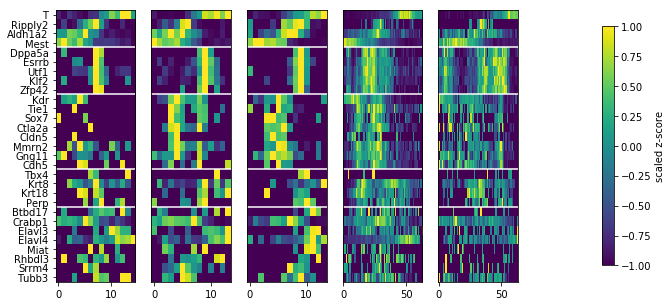

In [113]:
plt.figure(figsize=(10,5))
for i, df in enumerate(znfdfs):
    plt.subplot(1, len(znfdfs)+1, i+1)
    plt.imshow(scalezscore(df.loc[SCgenes]), aspect = 'auto')
    if i == 0:
        plt.yticks(range(len(SCgenes)), [x.rsplit('_')[1] for x in SCgenes])
    else:
        plt.yticks([])
    plt.axhline(3.5, c= 'w')
    plt.axhline(8.5, c= 'w')
    plt.axhline(16.5, c= 'w')
    plt.axhline(20.5, c= 'w')
    
plt.subplot(1, len(znfdfs)+1, i+2, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSC/'
plt.savefig(path + 'heatmap_5Gst_diffSCgenes.pdf')
plt.show()
    

In [130]:
path

'/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSC/'

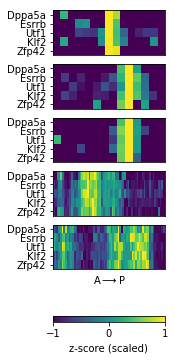

In [140]:
scgenes = ['Dppa5a','Esrrb','Utf1','Klf2','Zfp42']
SCgenes = []
for g in scgenes:
    xs = [x for x in znfdfs[0].index if '_' + g + '__' in x]
    if len(xs)==1:
        SCgenes.append(xs[0])

plt.figure(figsize=(2,5.75))

for i, df in enumerate(znfdfs):
    plt.subplot(len(znfdfs)+1, 1, i+1)
    plt.imshow(scalezscore(df.loc[SCgenes]), aspect = 'auto')
    plt.yticks(range(len(SCgenes)), [g.rsplit('_')[1] for g in SCgenes])
    plt.xticks([])
plt.xlabel(r'$\rm{A} \longrightarrow \rm{P}$')
plt.subplot(len(znfdfs)+1, 1, i+2, frameon = False); plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'z-score (scaled)', orientation = 'horizontal', ticks = [-1,0,1])

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSC/'
plt.savefig(path + 'PGCs.pdf', bbox_inches = 'tight')

plt.show()
    

In [134]:
help(plt.colorbar)

Help on function colorbar in module matplotlib.pyplot:

colorbar(mappable=None, cax=None, ax=None, **kw)
    Add a colorbar to a plot.
    
    Function signatures for the :mod:`~matplotlib.pyplot` interface; all
    but the first are also method signatures for the
    :meth:`~matplotlib.figure.Figure.colorbar` method::
    
      colorbar(**kwargs)
      colorbar(mappable, **kwargs)
      colorbar(mappable, cax=cax, **kwargs)
      colorbar(mappable, ax=ax, **kwargs)
    
    Parameters
    ----------
    mappable :
        The :class:`~matplotlib.image.Image`,
        :class:`~matplotlib.contour.ContourSet`, etc. to
        which the colorbar applies; this argument is mandatory for the Figure
        :meth:`~matplotlib.figure.Figure.colorbar` method but optional for the
        pyplot :func:`~matplotlib.pyplot.colorbar` function, which sets the
        default to the current image.
    
    cax : :class:`~matplotlib.axes.Axes` object, optional
        Axes into which the colorbar wil

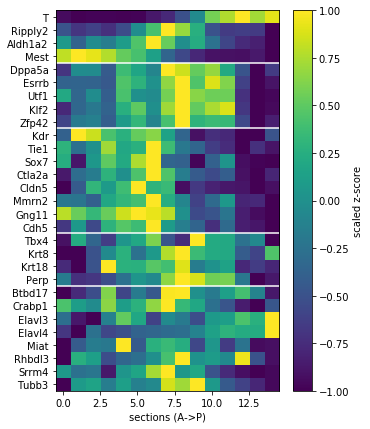

In [96]:
plt.figure(figsize=(5,7))
plt.imshow(scalezscore(xdf.loc[SCgenes]), aspect = 'auto')
plt.yticks(range(len(SCgenes)), [x.rsplit('_')[1] for x in SCgenes])
plt.colorbar(label = 'scaled z-score')
plt.xlabel('sections (A->P)')
plt.axhline(3.5, c= 'w')
plt.axhline(8.5, c= 'w')
plt.axhline(16.5, c= 'w')
plt.axhline(20.5, c= 'w')
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSC/'
plt.savefig(path + 'heatmap_avGst_diffSCgenes.pdf')
plt.show()